#  Artificial Intelligence                                              
 

## Project 1:  Modern Low Footprint Cyber Attack Detection 

### Developed By:                        
        
        Vrushank Shah

### Problem Formulation:

This project aims to build a network intrusion detector, which is a predictive model that is capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections. This problem has been addressed as a binary classification problem.

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import ModelCheckpoint

# Set the desired TensorFlow output level for this example
# tf.logging.set_verbosity(tf.logging.ERROR)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Combine training and testing data into a single csv file

In [2]:
import os
import glob
import pandas as pd
os.chdir(r'C:\Users\16696\Desktop\AI_Project1')


In [5]:
#Do not execute this again as it will create duplicate entries
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [6]:
#Do not execute this again as it will create duplicate entries
#Combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_data.csv", index=False, encoding='utf-8-sig')

# Data Preprocessing

In [3]:
#Read the file containing combined training and test data 
#Convert missing values to NaN
combined_data = pd.read_csv(r'C:\Users\16696\Desktop\AI_Project1\combined_data.csv',na_values=['NA','-'])

In [4]:
#Drop rows with NaN
combined_data.dropna(inplace=True)

In [5]:
combined_data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,36,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,...,1,2,0,0,1,1,3,0,Normal,0
40,41,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,...,1,2,0,0,1,1,3,0,Normal,0
45,46,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,...,1,1,0,0,1,3,1,0,Normal,0
49,50,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,...,1,2,0,0,1,1,2,0,Normal,0
72,73,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,...,1,1,0,0,1,2,1,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,175336,0.000006,udp,dns,INT,2,0,114,0,166666.660800,...,17,45,0,0,0,33,45,0,Generic,1
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [6]:
#Check for null values
print(combined_data.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [7]:
#Drop the 'id' column as it has no effect on the target feature 'label'
combined_data.drop('id',axis=1,inplace=True)

In [8]:
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,...,1,2,0,0,1,1,3,0,Normal,0
40,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,...,1,2,0,0,1,1,3,0,Normal,0
45,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,...,1,1,0,0,1,3,1,0,Normal,0
49,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,...,1,2,0,0,1,1,2,0,Normal,0
72,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,...,1,1,0,0,1,2,1,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,udp,dns,INT,2,0,114,0,166666.660800,254,...,17,45,0,0,0,33,45,0,Generic,1
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,13,24,0,0,0,24,24,0,Generic,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,14,30,0,0,0,30,30,0,Generic,1


In [9]:
#Encode categorical features by OneHotEncoding
encode_text_dummy(combined_data,'proto')
encode_text_dummy(combined_data,'service')
encode_text_dummy(combined_data,'attack_cat')
encode_text_dummy(combined_data,'state')

In [10]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
35,0.983874,10,8,816,1172,17.278635,62,252,5.976375e+03,8342.531250,...,0,1,0,0,0,0,1,0,0,0
40,1.535254,10,10,826,1266,12.375802,62,252,3.876883e+03,5940.385254,...,0,1,0,0,0,0,1,0,0,0
45,1.059359,10,8,830,1134,16.047441,62,252,5.641147e+03,7498.874512,...,0,1,0,0,0,0,1,0,0,0
49,0.990548,10,10,804,1414,19.181301,62,252,5.847268e+03,10281.177730,...,0,1,0,0,0,0,1,0,0,0
72,1.303518,12,8,898,1120,14.575939,62,252,5.057084e+03,6014.492676,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,2,0,114,0,166666.660800,254,0,7.600000e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
257668,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
257670,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
257671,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0


In [11]:
#Create a copy and drop 'label' to separate target feature from other feautures
combined_data_copy = combined_data.copy()
combined_data_copy.drop('label',axis=1,inplace=True)

In [12]:
#Create variables x and y for the train_test_split function
x=combined_data_copy
y=combined_data['label']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [13]:
x_train.shape

(93081, 68)

In [14]:
x_train

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
236095,0.000003,2,0,114,0,333333.321500,254,0,1.520000e+08,0.000000e+00,...,1,0,0,0,0,0,0,1,0,0
239514,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000e+00,...,1,0,0,0,0,0,0,1,0,0
175415,0.511469,10,8,806,1192,33.237596,62,252,1.135553e+04,1.631379e+04,...,0,1,0,0,0,0,1,0,0,0
236785,0.000008,2,0,114,0,125000.000300,254,0,5.700000e+07,0.000000e+00,...,1,0,0,0,0,0,0,1,0,0
183532,1.164322,8,10,364,3754,14.600772,62,252,2.191833e+03,2.321695e+04,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38922,1.074940,14,18,1684,10168,28.838820,31,29,1.163972e+04,7.147562e+04,...,0,1,0,0,0,0,1,0,0,0
107583,1.903370,364,746,19410,1087890,582.650765,31,29,8.135885e+04,4.566351e+06,...,0,1,0,0,0,0,1,0,0,0
100146,0.001089,2,2,146,178,2754.820869,31,29,5.362718e+05,6.538108e+05,...,0,1,0,0,0,1,0,0,0,0
102184,0.002849,6,8,320,1932,4563.004498,31,29,7.497368e+05,4.748332e+06,...,0,1,0,0,0,0,1,0,0,0


In [15]:
y_train.shape

(93081,)

In [16]:
x_test.shape

(23271, 68)

In [17]:
x_test

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
121771,0.001010,2,2,130,162,2.970297e+03,31,29,5.148515e+05,641584.125000,...,0,1,0,0,0,1,0,0,0,0
206776,0.000006,2,0,114,0,1.666667e+05,254,0,7.600000e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
220009,0.000005,2,0,114,0,2.000000e+05,254,0,9.120000e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
163448,1.317914,20,74,1214,87272,7.056606e+01,62,252,7.005009e+03,522601.625000,...,0,0,0,0,0,0,1,0,0,0
206846,0.261233,10,8,852,1264,6.507600e+01,62,252,2.348861e+04,33870.144530,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204926,0.000001,2,0,114,0,1.000000e+06,254,0,4.560000e+08,0.000000,...,1,0,0,0,0,0,0,1,0,0
107729,0.223370,8,12,424,8824,8.506066e+01,31,29,1.328737e+04,289707.656300,...,0,1,0,0,0,0,1,0,0,0
250355,0.000005,2,0,114,0,2.000000e+05,254,0,9.120000e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
232970,0.000010,2,0,114,0,1.000000e+05,254,0,4.560000e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0


In [18]:
y_test.shape

(23271,)

In [19]:
#Export to csv file to check for null values
x_train.to_csv( r'C:\Users\16696\Desktop\AI_Project1\x_train.csv', index=False, encoding='utf-8-sig')

In [20]:
x_train.columns[0:38]

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst'],
      dtype='object')

In [21]:
#Normalize all numerical columns except the OneHotEncoded columns and the 'is_sm_ips_ports' column as encoding this column will result in NaN values which will not be accepted by the machine learning models
for column_name in x_train.columns[0:38]:
    encode_numeric_zscore(x_train, column_name)
for column_name in x_test.columns[0:38]:
    encode_numeric_zscore(x_test, column_name)

C:\Users\16696\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
x_train

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
236095,-0.197673,-0.097914,-0.124311,-0.055655,-0.076721,1.349603,0.813338,-0.711906,1.293732,-0.216665,...,1,0,0,0,0,0,0,1,0,0
239514,-0.197671,-0.097914,-0.124311,-0.055655,-0.076721,0.027282,0.813338,-0.711906,0.019463,-0.216665,...,1,0,0,0,0,0,0,1,0,0
175415,-0.072608,-0.054793,-0.067852,-0.052801,-0.070363,-0.633680,-1.058429,1.562260,-0.617529,-0.199898,...,0,1,0,0,0,0,1,0,0,0
236785,-0.197672,-0.097914,-0.124311,-0.055655,-0.076721,0.109927,0.813338,-0.711906,0.099105,-0.216665,...,1,0,0,0,0,0,0,1,0,0
183532,0.087029,-0.065573,-0.053737,-0.054623,-0.056696,-0.633791,-1.058429,1.562260,-0.617645,-0.192803,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38922,0.065173,-0.033232,0.002722,-0.049179,-0.022482,-0.633706,-1.360641,-0.450197,-0.617526,-0.143203,...,0,1,0,0,0,0,1,0,0,0
107583,0.267743,1.853322,5.140513,0.023929,5.726433,-0.630411,-1.360641,-0.450197,-0.616649,4.476608,...,0,1,0,0,0,0,1,0,0,0
100146,-0.197407,-0.097914,-0.110196,-0.055523,-0.075772,-0.617486,-1.360641,-0.450197,-0.610929,0.455318,...,0,1,0,0,0,1,0,0,0,0
102184,-0.196977,-0.076353,-0.067852,-0.054805,-0.066415,-0.606726,-1.360641,-0.450197,-0.608244,4.663648,...,0,1,0,0,0,0,1,0,0,0


In [23]:
x_test

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
121771,-0.198711,-0.101666,-0.142244,-0.056640,-0.091722,-0.610800,-1.367643,-0.452872,-0.610244,0.467560,...,0,1,0,0,0,1,0,0,0,0
206776,-0.198972,-0.101666,-0.162885,-0.056714,-0.093000,0.353491,0.811110,-0.713797,0.338079,-0.212609,...,1,0,0,0,0,0,0,1,0,0
220009,-0.198973,-0.101666,-0.162885,-0.056714,-0.093000,0.549849,0.811110,-0.713797,0.529038,-0.212609,...,1,0,0,0,0,0,0,1,0,0
163448,0.144302,0.006601,0.600798,-0.051646,0.595687,-0.627882,-1.064767,1.553550,-0.616624,0.341422,...,0,0,0,0,0,0,1,0,0,0
206846,-0.130931,-0.053547,-0.080324,-0.053314,-0.083025,-0.627914,-1.064767,1.553550,-0.616417,-0.176702,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204926,-0.198974,-0.101666,-0.162885,-0.056714,-0.093000,5.262436,0.811110,-0.713797,5.112037,-0.212609,...,1,0,0,0,0,0,0,1,0,0
107729,-0.140793,-0.065577,-0.039044,-0.055286,-0.023367,-0.627796,-1.367643,-0.452872,-0.616545,0.094522,...,0,1,0,0,0,0,1,0,0,0
250355,-0.198973,-0.101666,-0.162885,-0.056714,-0.093000,0.549849,0.811110,-0.713797,0.529038,-0.212609,...,1,0,0,0,0,0,0,1,0,0
232970,-0.198971,-0.101666,-0.162885,-0.056714,-0.093000,-0.039224,0.811110,-0.713797,-0.043837,-0.212609,...,1,0,0,0,0,0,0,1,0,0


# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# instantiate the model 
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train.values, y_train.values)

# predict the response for new observations
y_predict = logreg.predict(x_test.values)
y_predict

C:\Users\16696\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

[[ 5737     0]
 [    0 17534]]


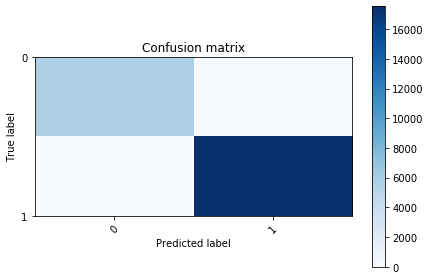

In [25]:
#Plot confusion matrix
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test,y_predict)
print(cm)
plot_confusion_matrix(cm,['0','1'])

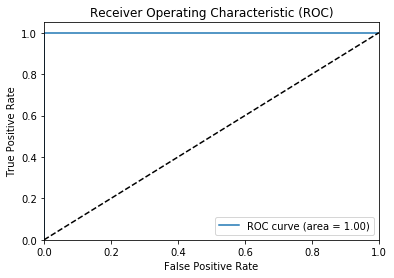

In [26]:
#Plot ROC curve
plot_roc(y_predict, y_test)

In [27]:
#Calculate Accuracy
score = metrics.accuracy_score(y_test, y_predict)
print("Accuracy score: {}".format(score))

Accuracy score: 1.0


In [28]:
#Calculate Precision
score = metrics.precision_score(y_test, y_predict, average="weighted")
print("Precision score: {}".format(score))

Precision score: 1.0


In [29]:
#Calculate Recall
score = metrics.recall_score(y_test, y_predict, average="weighted")
print("Recall score: {}".format(score))

Recall score: 1.0


In [30]:
#Calculate F1 Score
score = metrics.f1_score(y_test, y_predict, average="weighted")
print("F1 score: {}".format(score))

F1 score: 1.0


In [31]:
#Calculate Classification Report
print(metrics.classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       1.00      1.00      1.00     17534

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



# KNN 

In [32]:
#We have taken the value of k as 3
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [33]:
y_predict_knn = classifier.predict(x_test)

In [34]:
y_predict_knn

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

[[ 5709    28]
 [   20 17514]]


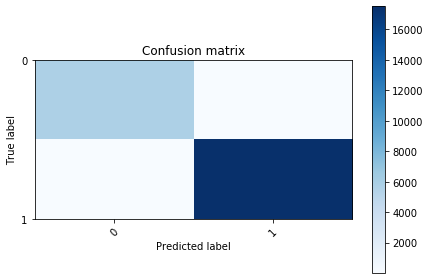

In [35]:
#Plot Confusion matrix
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test,y_predict_knn)
print(cm)
plt.figure()
plot_confusion_matrix(cm,[0, 1])
plt.show()

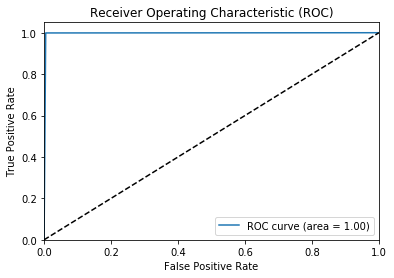

In [36]:
#Plot ROC Curve
plot_roc(y_predict_knn,y_test)

In [37]:
#Calculate Accuracy
score = metrics.accuracy_score(y_test, y_predict_knn)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9979373469124662


In [38]:
#Calculate Precision
score = metrics.precision_score(y_test, y_predict_knn, average="weighted")
print("Precision score: {}".format(score))

Precision score: 0.9979366955123704


In [39]:
#Calculate Recall
score = metrics.recall_score(y_test, y_predict_knn, average="weighted")
print("Recall score: {}".format(score))

Recall score: 0.9979373469124662


In [40]:
#Calculate F1 Score
score = metrics.f1_score(y_test, y_predict_knn, average="weighted")
print("F1 score: {}".format(score))

F1 score: 0.9979368625614996


In [41]:
#Display classification Report
print(metrics.classification_report(y_test,y_predict_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       1.00      1.00      1.00     17534

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



# SVM 

In [42]:
#We have used rbf kernel here
from sklearn.svm import SVC
svm_obj = SVC(kernel = 'rbf')
svm_obj.fit(x_train, y_train)
y_predict_svm = svm_obj.predict(x_test)

C:\Users\16696\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[ 5733     4]
 [    0 17534]]


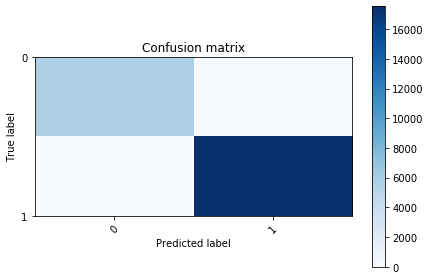

In [43]:
#Plot Confusion matrix
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test,y_predict_svm)
print(cm)
plt.figure()
plot_confusion_matrix(cm,[0, 1])
plt.show()

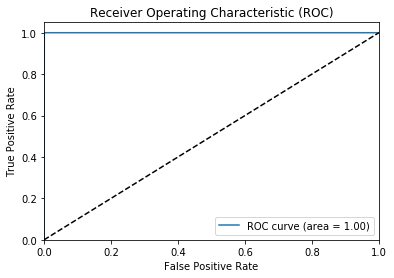

In [44]:
#Plot ROC Curve
plot_roc(y_predict_svm,y_test)

In [45]:
#Calculate Accuracy
score = metrics.accuracy_score(y_test, y_predict_svm)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9998281122427055


In [46]:
#Calulate Precision
score = metrics.precision_score(y_test, y_predict_svm, average="weighted")
print("Precision score: {}".format(score))

Precision score: 0.9998281514462082


In [47]:
#Calculate Recall
score = metrics.recall_score(y_test, y_predict_svm, average="weighted")
print("Recall score: {}".format(score))

Recall score: 0.9998281122427055


In [48]:
#Calculate F1 Score
score = metrics.f1_score(y_test, y_predict_knn, average="weighted")
print("F1 score: {}".format(score))

F1 score: 0.9979368625614996


In [49]:
#Display Classification Report
print(metrics.classification_report(y_test,y_predict_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       1.00      1.00      1.00     17534

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



# Neural Network with 'relu' as activation function and 'sgd' as optimizer

In [50]:
import os
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [51]:
x_train.values.astype(np.float32)
x_test.values.astype(np.float32)

array([[-0.19871089, -0.10166573, -0.14224446, ...,  0.        ,
         0.        ,  0.        ],
       [-0.19897239, -0.10166573, -0.16288452, ...,  1.        ,
         0.        ,  0.        ],
       [-0.19897266, -0.10166573, -0.16288452, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.19897266, -0.10166573, -0.16288452, ...,  1.        ,
         0.        ,  0.        ],
       [-0.19897136, -0.10166573, -0.16288452, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.0556858 ,  0.06674922,  0.08479623, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [52]:
#Converts a class vector (integers) to binary class matrix.
#This function takes a vector or 1 column matrix of class labels and converts it into a matrix with p columns, one for each category. This is the format most commonly used in the fitting and predicting of neural networks.
y_train = to_categorical(y_train)             
y_test = to_categorical(y_test)     

In [53]:
y_train.shape

(93081, 2)

In [54]:
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [55]:
y_test.shape

(23271, 2)

In [56]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [57]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined.hdf5', verbose=0, save_best_only=True)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Dense(68, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(34,activation='relu'))
    model.add(Dense(34,activation='relu'))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=50)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined.hdf5')

# Measure accuracy
predict_neural = model.predict(x_test)
predict_neural = np.argmax(predict_neural,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, predict_neural)
print("Final accuracy: {}".format(score))

0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 19s - loss: 0.0528 - val_loss: 0.0075
Epoch 2/50
93081/93081 - 18s - loss: 0.0046 - val_loss: 0.0063
Epoch 3/50
93081/93081 - 14s - loss: 0.0029 - val_loss: 0.0023
Epoch 4/50
93081/93081 - 11s - loss: 0.0016 - val_loss: 9.6526e-04
Epoch 5/50
93081/93081 - 14s - loss: 0.0015 - val_loss: 0.0012
Epoch 6/50
93081/93081 - 12s - loss: 0.0015 - val_loss: 3.9201e-04
Epoch 7/50
93081/93081 - 15s - loss: 8.3469e-04 - val_loss: 7.3716e-04
Epoch 8/50
93081/93081 - 13s - loss: 5.7534e-04 - val_loss: 7.3646e-04
Epoch 9/50
93081/93081 - 14s - loss: 7.1142e-04 - val_loss: 0.0013
Epoch 00009: early stopping
1
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 11s - loss: 0.0517 - val_loss: 0.0051
Epoch 2/50
93081/93081 - 12s - loss: 0.0031 - val_loss: 0.0015
Epoch 3/50
93081/93081 - 13s - loss: 0.0017 - val_loss: 0.0026
Epo

In [58]:
#Calculate Accuracy
score = metrics.accuracy_score(y_true, predict_neural)

print("Accuracy score: {}".format(score))

Accuracy score: 0.9999570280606763


In [59]:
#Calculate Recall
score = metrics.recall_score(y_true, predict_neural, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.9999570280606763


In [60]:
#Calculate Precision
score = metrics.precision_score(y_true, predict_neural, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.9999570355496863


In [61]:
#Calculate F1 Score
score = metrics.f1_score(y_true, predict_neural, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.99995702932038


[[ 5737     0]
 [    1 17533]]
Plotting confusion matrix


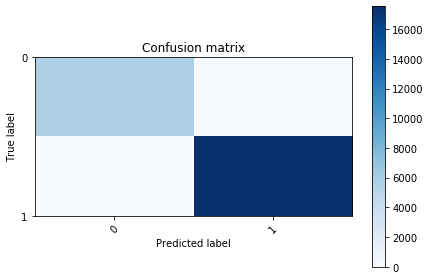

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       1.00      1.00      1.00     17534

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



In [62]:
#Plot Confusion matrix and Classification report
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, predict_neural)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0','1'])
plt.show()

print(classification_report(y_true, predict_neural))

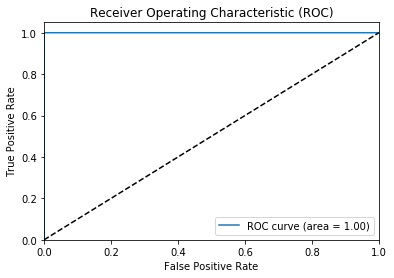

In [63]:
#Plot ROC Curve
plot_roc(predict_neural,y_true)

# Neural Network with 'relu' as activation function and 'adam' as optimizer 

In [64]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_adam.hdf5', verbose=0, save_best_only=True)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Dense(44, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(24,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=50)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_adam.hdf5')

# Measure accuracy
predict_neural = model.predict(x_test)
predict_neural = np.argmax(predict_neural,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, predict_neural)
print("Final accuracy: {}".format(score))

0
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 16s - loss: 0.0171 - val_loss: 0.0021
Epoch 2/50
93081/93081 - 15s - loss: 0.0011 - val_loss: 6.8356e-04
Epoch 3/50
93081/93081 - 16s - loss: 5.8564e-04 - val_loss: 0.0014
Epoch 4/50
93081/93081 - 15s - loss: 8.6182e-04 - val_loss: 6.4176e-04
Epoch 5/50
93081/93081 - 14s - loss: 4.3877e-04 - val_loss: 3.5146e-04
Epoch 6/50
93081/93081 - 13s - loss: 4.5996e-04 - val_loss: 2.9408e-04
Epoch 7/50
93081/93081 - 13s - loss: 1.6930e-04 - val_loss: 4.5868e-05
Epoch 00007: early stopping
1
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 13s - loss: 0.0173 - val_loss: 0.0014
Epoch 2/50
93081/93081 - 14s - loss: 0.0011 - val_loss: 0.0010
Epoch 3/50
93081/93081 - 12s - loss: 4.7618e-04 - val_loss: 0.0027
Epoch 4/50
93081/93081 - 14s - loss: 5.1992e-04 - val_loss: 1.4637e-04
Epoch 5/50
93081/93081 - 14s - loss: 2.5755e-04 - val_loss: 1.6412e-05
Epoch 6/50
93081/93081 - 16s - loss: 1.8017e-07 - va

[[ 5737     0]
 [    0 17534]]
Plotting confusion matrix


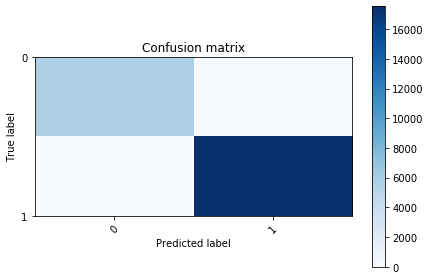

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       1.00      1.00      1.00     17534

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



In [65]:
#Plot Confusion matrix and Classification report
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, predict_neural)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0','1'])
plt.show()

print(classification_report(y_true, predict_neural))

In [66]:
#Calculate Recall
score = metrics.recall_score(y_true, predict_neural, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 1.0


In [67]:
#Calculate Precision
score = metrics.precision_score(y_true, predict_neural, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 1.0


In [68]:
#Calculate F1 Score
score = metrics.f1_score(y_true, predict_neural, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 1.0


# Neural Network with 'sigmoid' as activation function and 'sgd' as optimizer 

In [69]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_sigmoid_sgd.hdf5', verbose=0, save_best_only=True)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Dense(44, input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(Dense(22,activation='sigmoid'))
    model.add(Dense(22,activation='sigmoid'))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=50)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_sigmoid_sgd.hdf5')

# Measure accuracy
predict_neural = model.predict(x_test)
predict_neural = np.argmax(predict_neural,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, predict_neural)
print("Final accuracy: {}".format(score))

0
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 19s - loss: 0.5557 - val_loss: 0.5290
Epoch 2/50
93081/93081 - 18s - loss: 0.4227 - val_loss: 0.2444
Epoch 3/50
93081/93081 - 12s - loss: 0.1416 - val_loss: 0.0861
Epoch 4/50
93081/93081 - 12s - loss: 0.0573 - val_loss: 0.0393
Epoch 5/50
93081/93081 - 17s - loss: 0.0271 - val_loss: 0.0199
Epoch 6/50
93081/93081 - 14s - loss: 0.0149 - val_loss: 0.0120
Epoch 7/50
93081/93081 - 14s - loss: 0.0095 - val_loss: 0.0080
Epoch 8/50
93081/93081 - 14s - loss: 0.0066 - val_loss: 0.0058
Epoch 9/50
93081/93081 - 13s - loss: 0.0049 - val_loss: 0.0044
Epoch 10/50
93081/93081 - 15s - loss: 0.0039 - val_loss: 0.0035
Epoch 11/50
93081/93081 - 15s - loss: 0.0032 - val_loss: 0.0029
Epoch 12/50
93081/93081 - 13s - loss: 0.0026 - val_loss: 0.0024
Epoch 13/50
93081/93081 - 14s - loss: 0.0022 - val_loss: 0.0021
Epoch 14/50
93081/93081 - 16s - loss: 0.0020 - val_loss: 0.0018
Epoch 15/50
93081/93081 - 13s - loss: 0.0017 - val_loss: 0.00

[[ 5736     1]
 [    0 17534]]
Plotting confusion matrix


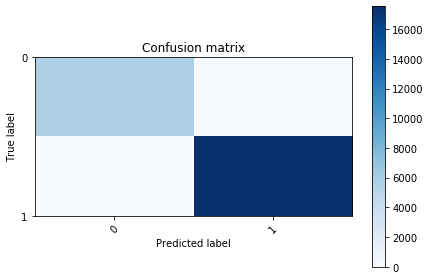

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       1.00      1.00      1.00     17534

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



In [70]:
#Plot Confusion matrix and display Classification report
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, predict_neural)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0','1'])
plt.show()

print(classification_report(y_true, predict_neural))

In [71]:
#Calculate Recall
score = metrics.recall_score(y_true, predict_neural, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.9999570280606763


In [72]:
#Calculate Precision
score = metrics.precision_score(y_true, predict_neural, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.9999570305113145


In [73]:
#Calculate F1 Score
score = metrics.f1_score(y_true, predict_neural, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.9999570268006113


# Neural Network with 'tanh' as activation function and 'sgd' as optimizer

In [74]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_tanh_sgd.hdf5', verbose=0, save_best_only=True)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Dense(44, input_dim=x_train.shape[1], activation='tanh'))
    model.add(Dense(22,activation='tanh'))
    model.add(Dense(22,activation='tanh'))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=50)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_tanh_sgd.hdf5')

# Measure accuracy
predict_neural = model.predict(x_test)
predict_neural = np.argmax(predict_neural,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, predict_neural)
print("Final accuracy: {}".format(score))

0
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 17s - loss: 0.0439 - val_loss: 0.0055
Epoch 2/50
93081/93081 - 15s - loss: 0.0035 - val_loss: 0.0024
Epoch 3/50
93081/93081 - 15s - loss: 0.0018 - val_loss: 0.0016
Epoch 4/50
93081/93081 - 11s - loss: 0.0012 - val_loss: 0.0012
Epoch 5/50
93081/93081 - 13s - loss: 8.9526e-04 - val_loss: 0.0011
Epoch 6/50
93081/93081 - 15s - loss: 7.2903e-04 - val_loss: 9.5120e-04
Epoch 7/50
93081/93081 - 14s - loss: 5.8729e-04 - val_loss: 9.8388e-04
Epoch 8/50
93081/93081 - 14s - loss: 5.4555e-04 - val_loss: 7.3453e-04
Epoch 9/50
93081/93081 - 14s - loss: 4.6608e-04 - val_loss: 8.0265e-04
Epoch 00009: early stopping
1
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 15s - loss: 0.0392 - val_loss: 0.0047
Epoch 2/50
93081/93081 - 15s - loss: 0.0034 - val_loss: 0.0020
Epoch 3/50
93081/93081 - 14s - loss: 0.0018 - val_loss: 0.0013
Epoch 4/50
93081/93081 - 14s - loss: 0.0013 - val_loss: 0.0010
Epoch 5/50
93

[[ 5732     5]
 [    1 17533]]
Plotting confusion matrix


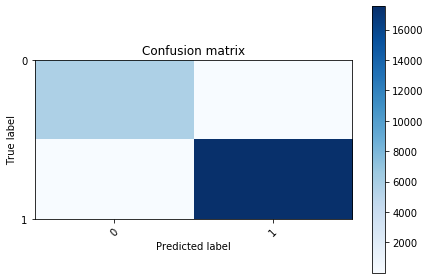

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       1.00      1.00      1.00     17534

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



In [75]:
#Plot Confusion matrix and display Classification report
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, predict_neural)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0','1'])
plt.show()

print(classification_report(y_true, predict_neural))

In [76]:
#Calculate Recall
score = metrics.recall_score(y_true, predict_neural, average= "weighted")
print("Recall score: {}".format(score))

Recall score: 0.9997421683640583


In [77]:
#Calculate Precision
score = metrics.precision_score(y_true, predict_neural, average= "weighted")
print("Precision score: {}".format(score))

Precision score: 0.9997421873862706


In [78]:
#Calculate F1 Score
score = metrics.f1_score(y_true, predict_neural, average= "weighted")
print("F1 score: {}".format(score))

F1 score: 0.9997421381094833


# Additional Features

# (1) Feature Selection

In [79]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import ModelCheckpoint

# Set the desired TensorFlow output level for this example
# tf.logging.set_verbosity(tf.logging.ERROR)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [80]:
combined_data = pd.read_csv(r'C:\Users\16696\Desktop\AI_Project1\combined_data.csv',na_values=['NA','-'])

In [81]:
combined_data.dropna(inplace=True)

In [82]:
combined_data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,36,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,...,1,2,0,0,1,1,3,0,Normal,0
40,41,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,...,1,2,0,0,1,1,3,0,Normal,0
45,46,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,...,1,1,0,0,1,3,1,0,Normal,0
49,50,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,...,1,2,0,0,1,1,2,0,Normal,0
72,73,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,...,1,1,0,0,1,2,1,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,175336,0.000006,udp,dns,INT,2,0,114,0,166666.660800,...,17,45,0,0,0,33,45,0,Generic,1
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [83]:
combined_data.drop('id',axis=1,inplace=True)

In [84]:
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,...,1,2,0,0,1,1,3,0,Normal,0
40,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,...,1,2,0,0,1,1,3,0,Normal,0
45,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,...,1,1,0,0,1,3,1,0,Normal,0
49,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,...,1,2,0,0,1,1,2,0,Normal,0
72,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,...,1,1,0,0,1,2,1,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,udp,dns,INT,2,0,114,0,166666.660800,254,...,17,45,0,0,0,33,45,0,Generic,1
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,13,24,0,0,0,24,24,0,Generic,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,14,30,0,0,0,30,30,0,Generic,1


In [85]:
encode_text_dummy(combined_data,'proto')
encode_text_dummy(combined_data,'service')
encode_text_dummy(combined_data,'attack_cat')
encode_text_dummy(combined_data,'state')

In [86]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
35,0.983874,10,8,816,1172,17.278635,62,252,5.976375e+03,8342.531250,...,0,1,0,0,0,0,1,0,0,0
40,1.535254,10,10,826,1266,12.375802,62,252,3.876883e+03,5940.385254,...,0,1,0,0,0,0,1,0,0,0
45,1.059359,10,8,830,1134,16.047441,62,252,5.641147e+03,7498.874512,...,0,1,0,0,0,0,1,0,0,0
49,0.990548,10,10,804,1414,19.181301,62,252,5.847268e+03,10281.177730,...,0,1,0,0,0,0,1,0,0,0
72,1.303518,12,8,898,1120,14.575939,62,252,5.057084e+03,6014.492676,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,2,0,114,0,166666.660800,254,0,7.600000e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
257668,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
257670,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0
257671,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,1,0,0,0,0,0,0,1,0,0


# Correlation function for feature selection 

In [87]:
#Display features having less than 0.1 correlation with 'label' feature i.e. target feature
correlation_list = combined_data[combined_data.columns[:]].corr()['label']
correlation_list = [columns for columns in correlation_list.index if correlation_list[columns] < 0.1]
print(correlation_list)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'dttl', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'synack', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'proto-tcp', 'service-dhcp', 'service-ftp', 'service-ftp-data', 'service-http', 'service-irc', 'service-pop3', 'service-radius', 'service-smtp', 'service-snmp', 'service-ssh', 'service-ssl', 'attack_cat-Analysis', 'attack_cat-Backdoor', 'attack_cat-DoS', 'attack_cat-Fuzzers', 'attack_cat-Normal', 'attack_cat-Reconnaissance', 'attack_cat-Worms', 'state-ACC', 'state-CON', 'state-FIN', 'state-REQ', 'state-RST']


In [88]:
#Drop feautures as listed in the correlation list
combined_data = combined_data.drop(correlation_list, axis = 1)

In [89]:
combined_data

,rate,sttl,sload,tcprtt,ackdat,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto-udp,service-dns,attack_cat-Exploits,attack_cat-Generic,state-INT
35,17.278635,62,5.976375e+03,0.206572,0.098179,2,1,1,1,1,2,1,3,0,0,0,0,0,0,0
40,12.375802,62,3.876883e+03,0.180318,0.076706,2,1,1,1,1,2,1,3,0,0,0,0,0,0,0
45,16.047441,62,5.641147e+03,0.274887,0.146428,1,1,1,1,1,1,3,1,0,0,0,0,0,0,0
49,19.181301,62,5.847268e+03,0.181441,0.097192,2,1,18,1,1,2,1,2,0,0,0,0,0,0,0
72,14.575939,62,5.057084e+03,0.140062,0.065552,1,1,1,1,1,1,2,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,166666.660800,254,7.600000e+07,0.000000,0.000000,45,2,33,33,17,45,33,45,0,1,1,1,0,1,1
257668,111111.107200,254,5.066666e+07,0.000000,0.000000,24,2,24,24,13,24,24,24,0,1,1,1,0,1,1
257670,111111.107200,254,5.066666e+07,0.000000,0.000000,12,2,3,3,3,13,3,12,0,1,1,1,0,1,1
257671,111111.107200,254,5.066666e+07,0.000000,0.000000,30,2,30,30,14,30,30,30,0,1,1,1,0,1,1


In [90]:
combined_data_copy = combined_data.copy()
combined_data_copy.drop('label',axis=1,inplace=True)

In [91]:
x=combined_data_copy
y=combined_data['label']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [92]:
x_train.shape

(93081, 19)

In [93]:
x_test.shape

(23271, 19)

In [94]:
#Select all numeric columns for normalization except the OneHotEncoded columns and the 'is_sm_ips_ports' column
for column_name in x_train.columns[0:13]:
    encode_numeric_zscore(x_train, column_name)
for column_name in x_test.columns[0:13]:
    encode_numeric_zscore(x_test, column_name)

C:\Users\16696\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
x_train

,rate,sttl,sload,tcprtt,ackdat,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto-udp,service-dns,attack_cat-Exploits,attack_cat-Generic,state-INT
236095,1.349603,0.813338,1.293732,-0.546328,-0.540294,1.270452,0.852912,0.488432,0.548506,1.068040,1.278007,0.547254,1.271811,0,1,1,0,1,1
239514,0.027282,0.813338,0.019463,-0.546328,-0.540294,1.487923,0.852912,-0.087307,-0.016207,-0.419058,1.492655,-0.125709,1.488973,0,1,1,0,1,1
175415,-0.633680,-1.058429,-0.617529,1.361005,1.512241,-0.614301,-0.360927,-0.759003,-0.675038,-0.689439,-0.582274,-0.702534,-0.610258,0,0,0,0,0,0
236785,0.109927,0.813338,0.099105,-0.546328,-0.540294,1.487923,0.852912,2.503519,2.336761,1.473612,1.492655,2.277730,1.488973,0,1,1,0,1,1
183532,-0.633791,-1.058429,-0.617645,1.345689,1.025041,-0.904264,-0.360927,-0.567090,-0.769156,-0.824630,-0.796922,-0.414121,-0.899808,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38922,-0.633706,-1.360641,-0.617526,-0.538118,-0.537373,-0.831773,-1.574765,-0.854960,-0.769156,-0.824630,-0.868471,-0.702534,-0.899808,0,0,0,0,0,0
107583,-0.630411,-1.360641,-0.616649,-0.537252,-0.536766,-0.904264,-1.574765,-0.854960,-0.769156,-0.824630,-0.868471,-0.894809,-0.899808,0,0,0,0,0,0
100146,-0.617486,-1.360641,-0.610929,-0.546328,-0.540294,-0.759282,-1.574765,-0.567090,-0.769156,-0.824630,-0.796922,-0.894809,-0.827420,0,1,1,0,0,0
102184,-0.606726,-1.360641,-0.608244,-0.537581,-0.537026,-0.759282,-1.574765,-0.471133,-0.769156,-0.824630,-0.582274,-0.221846,-0.755033,0,0,0,0,0,0


In [96]:
x_test

,rate,sttl,sload,tcprtt,ackdat,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto-udp,service-dns,attack_cat-Exploits,attack_cat-Generic,state-INT
121771,-0.610800,-1.367643,-0.610244,-0.551794,-0.553741,-0.835609,-1.587730,-0.667266,-0.679269,-0.829763,-0.730636,-0.705366,-0.540432,0,1,1,0,0,0
206776,0.353491,0.811110,0.338079,-0.551794,-0.553741,1.196355,0.843784,0.779545,0.832664,1.471087,1.204567,0.838209,1.198079,0,1,1,0,1,1
220009,0.549849,0.811110,0.529038,-0.551794,-0.553741,1.486635,0.843784,1.647631,1.683127,1.471087,1.491264,1.609996,1.487831,0,1,1,0,1,1
163448,-0.627882,-1.064767,-0.616624,0.280341,0.669588,-0.835609,-0.371973,-0.667266,-0.679269,-0.829763,-0.802310,-0.801839,-0.757745,0,0,0,1,0,0
206846,-0.627914,-1.064767,-0.616417,0.359125,0.807051,-0.763039,-0.371973,-0.763720,-0.679269,-0.829763,-0.802310,-0.801839,-0.830183,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204926,5.262436,0.811110,5.112037,-0.551794,-0.553741,1.559206,0.843784,2.322810,2.344597,1.471087,1.562938,2.285310,1.560269,0,1,1,0,1,1
107729,-0.627796,-1.367643,-0.616545,-0.541543,-0.549550,-0.763039,-1.587730,-0.377904,-0.773764,-0.829763,-0.658961,-0.512419,-0.757745,0,0,0,0,0,0
250355,0.549849,0.811110,0.529038,-0.551794,-0.553741,0.833504,0.843784,-0.088542,-0.017798,0.252990,0.846196,-0.126525,0.835889,0,1,1,0,1,1
232970,-0.039224,0.811110,-0.043837,-0.551794,-0.553741,1.196355,0.843784,0.007912,0.076698,0.388334,1.204567,0.066422,1.198079,0,1,1,0,1,1


# Neural Network

In [97]:
import os
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [98]:
x_train.values.astype(np.float32)
x_test.values.astype(np.float32)

array([[-0.6108003 , -1.3676429 , -0.61024415, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35349143,  0.81111044,  0.33807936, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.5498493 ,  0.81111044,  0.5290377 , ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.5498493 ,  0.81111044,  0.5290377 , ...,  0.        ,
         1.        ,  1.        ],
       [-0.03922413,  0.81111044, -0.04383728, ...,  0.        ,
         1.        ,  1.        ],
       [-0.6282327 , -1.0647669 , -0.61651343, ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)

In [99]:
y_train = to_categorical(y_train)             #don't do again and again
y_test = to_categorical(y_test) 

In [100]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_featurereduction.hdf5', verbose=0, save_best_only=True)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Dense(44, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(22,activation='relu'))
    model.add(Dense(22,activation='relu'))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='SGD')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=50)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_featurereduction.hdf5')

# Measure accuracy
predict_neural = model.predict(x_test)
predict_neural = np.argmax(predict_neural,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, predict_neural)
print("Final accuracy: {}".format(score))

0
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 9s - loss: 0.0919 - val_loss: 0.0601
Epoch 2/50
93081/93081 - 7s - loss: 0.0562 - val_loss: 0.0582
Epoch 3/50
93081/93081 - 7s - loss: 0.0541 - val_loss: 0.0555
Epoch 4/50
93081/93081 - 7s - loss: 0.0529 - val_loss: 0.0554
Epoch 5/50
93081/93081 - 6s - loss: 0.0522 - val_loss: 0.0557
Epoch 6/50
93081/93081 - 6s - loss: 0.0515 - val_loss: 0.0546
Epoch 7/50
93081/93081 - 6s - loss: 0.0513 - val_loss: 0.0539
Epoch 8/50
93081/93081 - 6s - loss: 0.0506 - val_loss: 0.0531
Epoch 9/50
93081/93081 - 6s - loss: 0.0506 - val_loss: 0.0567
Epoch 10/50
93081/93081 - 6s - loss: 0.0502 - val_loss: 0.0545
Epoch 11/50
93081/93081 - 7s - loss: 0.0497 - val_loss: 0.0546
Epoch 12/50
93081/93081 - 7s - loss: 0.0496 - val_loss: 0.0537
Epoch 00012: early stopping
1
Train on 93081 samples, validate on 23271 samples
Epoch 1/50
93081/93081 - 7s - loss: 0.1002 - val_loss: 0.0621
Epoch 2/50
93081/93081 - 7s - loss: 0.0564 - val_loss: 0.05

[[ 5383   354]
 [  168 17366]]
Plotting confusion matrix


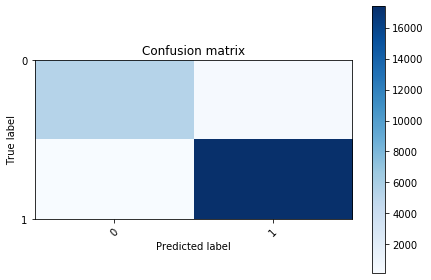

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5737
           1       0.98      0.99      0.99     17534

    accuracy                           0.98     23271
   macro avg       0.97      0.96      0.97     23271
weighted avg       0.98      0.98      0.98     23271



In [101]:
#Plot confusion matrix and display Classification report
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, predict_neural)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0','1'])
plt.show()

print(classification_report(y_true, predict_neural))

# (2) Multi-class Classification

In [102]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import ModelCheckpoint

# Set the desired TensorFlow output level for this example
# tf.logging.set_verbosity(tf.logging.ERROR)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [103]:
combined_data = pd.read_csv(r'C:\Users\16696\Desktop\AI_Project1\combined_data.csv',na_values=['NA','-'])

In [104]:
combined_data.dropna(inplace=True)

In [105]:
combined_data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,36,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,...,1,2,0,0,1,1,3,0,Normal,0
40,41,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,...,1,2,0,0,1,1,3,0,Normal,0
45,46,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,...,1,1,0,0,1,3,1,0,Normal,0
49,50,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,...,1,2,0,0,1,1,2,0,Normal,0
72,73,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,...,1,1,0,0,1,2,1,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,175336,0.000006,udp,dns,INT,2,0,114,0,166666.660800,...,17,45,0,0,0,33,45,0,Generic,1
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [106]:
combined_data.drop('id',axis=1,inplace=True)
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,...,1,2,0,0,1,1,3,0,Normal,0
40,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,...,1,2,0,0,1,1,3,0,Normal,0
45,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,...,1,1,0,0,1,3,1,0,Normal,0
49,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,...,1,2,0,0,1,1,2,0,Normal,0
72,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,...,1,1,0,0,1,2,1,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,udp,dns,INT,2,0,114,0,166666.660800,254,...,17,45,0,0,0,33,45,0,Generic,1
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,13,24,0,0,0,24,24,0,Generic,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,14,30,0,0,0,30,30,0,Generic,1


In [107]:
encode_text_dummy(combined_data,'proto')
encode_text_dummy(combined_data,'service')
encode_text_dummy(combined_data,'state')

In [108]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service-smtp,service-snmp,service-ssh,service-ssl,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
35,0.983874,10,8,816,1172,17.278635,62,252,5.976375e+03,8342.531250,...,0,0,0,0,0,0,1,0,0,0
40,1.535254,10,10,826,1266,12.375802,62,252,3.876883e+03,5940.385254,...,0,0,0,0,0,0,1,0,0,0
45,1.059359,10,8,830,1134,16.047441,62,252,5.641147e+03,7498.874512,...,0,0,0,0,0,0,1,0,0,0
49,0.990548,10,10,804,1414,19.181301,62,252,5.847268e+03,10281.177730,...,0,0,0,0,0,0,1,0,0,0
72,1.303518,12,8,898,1120,14.575939,62,252,5.057084e+03,6014.492676,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,2,0,114,0,166666.660800,254,0,7.600000e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0
257668,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0
257670,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0
257671,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0


In [109]:
#Label Encode the 'attack_cat' feature which is the target feature for multi-class classification
encode_text_index(combined_data,'attack_cat')

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Worms'], dtype=object)

In [110]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service-smtp,service-snmp,service-ssh,service-ssl,state-ACC,state-CON,state-FIN,state-INT,state-REQ,state-RST
35,0.983874,10,8,816,1172,17.278635,62,252,5.976375e+03,8342.531250,...,0,0,0,0,0,0,1,0,0,0
40,1.535254,10,10,826,1266,12.375802,62,252,3.876883e+03,5940.385254,...,0,0,0,0,0,0,1,0,0,0
45,1.059359,10,8,830,1134,16.047441,62,252,5.641147e+03,7498.874512,...,0,0,0,0,0,0,1,0,0,0
49,0.990548,10,10,804,1414,19.181301,62,252,5.847268e+03,10281.177730,...,0,0,0,0,0,0,1,0,0,0
72,1.303518,12,8,898,1120,14.575939,62,252,5.057084e+03,6014.492676,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,2,0,114,0,166666.660800,254,0,7.600000e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0
257668,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0
257670,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0
257671,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,0,0,0,0,0,0,0,1,0,0


In [111]:
combined_data['attack_cat']

35        6
40        6
45        6
49        6
72        6
         ..
257667    5
257668    5
257670    5
257671    5
257672    5
Name: attack_cat, Length: 116352, dtype: int32

In [112]:
#Select the columns with correlation less than 0.1
correlation_list = combined_data[combined_data.columns[:]].corr()['attack_cat']
correlation_list = [columns for columns in correlation_list.index if correlation_list[columns] < 0.1]
print(correlation_list)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_state_ttl', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'label', 'proto-tcp', 'service-dhcp', 'service-ftp', 'service-ftp-data', 'service-http', 'service-irc', 'service-pop3', 'service-radius', 'service-smtp', 'service-snmp', 'service-ssl', 'state-ACC', 'state-FIN', 'state-REQ', 'state-RST']


In [113]:
#Drop the less important features based on the above calculated correlation list
combined_data = combined_data.drop(correlation_list, axis = 1)

In [114]:
combined_data

,dload,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,proto-udp,service-dns,service-ssh,state-CON,state-INT
35,8342.531250,2,1,1,1,2,1,3,0,6,0,0,0,0,0
40,5940.385254,2,1,1,1,2,1,3,0,6,0,0,0,0,0
45,7498.874512,1,1,1,1,1,3,1,0,6,0,0,0,0,0
49,10281.177730,2,18,1,1,2,1,2,0,6,0,0,0,0,0
72,6014.492676,1,1,1,1,1,2,1,0,6,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000000,45,33,33,17,45,33,45,0,5,1,1,0,0,1
257668,0.000000,24,24,24,13,24,24,24,0,5,1,1,0,0,1
257670,0.000000,12,3,3,3,13,3,12,0,5,1,1,0,0,1
257671,0.000000,30,30,30,14,30,30,30,0,5,1,1,0,0,1


In [115]:
combined_data_copy = combined_data.copy()
combined_data_copy.drop('attack_cat',axis=1,inplace=True)

In [116]:
x=combined_data_copy
y=combined_data['attack_cat']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [117]:
x_train

,dload,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto-udp,service-dns,service-ssh,state-CON,state-INT
236095,0.000000e+00,31,15,15,15,31,16,31,0,1,1,0,0,1
239514,0.000000e+00,34,9,9,4,34,9,34,0,1,1,0,0,1
175415,1.631379e+04,5,2,2,2,5,3,5,0,0,0,0,0,0
236785,0.000000e+00,34,36,34,18,34,34,34,0,1,1,0,0,1
183532,2.321695e+04,1,4,1,1,2,6,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38922,7.147562e+04,2,1,1,1,1,3,1,0,0,0,0,0,0
107583,4.566351e+06,1,1,1,1,1,1,1,0,0,0,0,0,0
100146,6.538108e+05,3,4,1,1,2,1,2,0,1,1,0,1,0
102184,4.748332e+06,3,5,1,1,5,8,3,0,0,0,0,0,0


In [118]:
x_test

,dload,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto-udp,service-dns,service-ssh,state-CON,state-INT
121771,641584.125000,2,3,2,1,3,3,6,0,1,1,0,1,0
206776,0.000000,30,18,18,18,30,19,30,0,1,1,0,0,1
220009,0.000000,34,27,27,18,34,27,34,0,1,1,0,0,1
163448,522601.625000,2,3,2,1,2,2,3,0,0,0,0,0,0
206846,33870.144530,3,2,2,1,2,2,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204926,0.000000,35,34,34,18,35,34,35,0,1,1,0,0,1
107729,289707.656300,3,6,1,1,4,5,3,0,0,0,0,0,0
250355,0.000000,25,9,9,9,25,9,25,0,1,1,0,0,1
232970,0.000000,30,10,10,10,30,11,30,0,1,1,0,0,1


In [119]:
##Select all numeric columns for normalization except the OneHotEncoded columns and the 'is_sm_ips_ports' column
for column_name in x_train.columns[0:8]:
    encode_numeric_zscore(x_train, column_name)
for column_name in x_test.columns[0:8]:
    encode_numeric_zscore(x_test, column_name)

C:\Users\16696\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [120]:
x_train

,dload,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto-udp,service-dns,service-ssh,state-CON,state-INT
236095,-0.216665,1.270452,0.488432,0.548506,1.068040,1.278007,0.547254,1.271811,0,1,1,0,0,1
239514,-0.216665,1.487923,-0.087307,-0.016207,-0.419058,1.492655,-0.125709,1.488973,0,1,1,0,0,1
175415,-0.199898,-0.614301,-0.759003,-0.675038,-0.689439,-0.582274,-0.702534,-0.610258,0,0,0,0,0,0
236785,-0.216665,1.487923,2.503519,2.336761,1.473612,1.492655,2.277730,1.488973,0,1,1,0,0,1
183532,-0.192803,-0.904264,-0.567090,-0.769156,-0.824630,-0.796922,-0.414121,-0.899808,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38922,-0.143203,-0.831773,-0.854960,-0.769156,-0.824630,-0.868471,-0.702534,-0.899808,0,0,0,0,0,0
107583,4.476608,-0.904264,-0.854960,-0.769156,-0.824630,-0.868471,-0.894809,-0.899808,0,0,0,0,0,0
100146,0.455318,-0.759282,-0.567090,-0.769156,-0.824630,-0.796922,-0.894809,-0.827420,0,1,1,0,1,0
102184,4.663648,-0.759282,-0.471133,-0.769156,-0.824630,-0.582274,-0.221846,-0.755033,0,0,0,0,0,0


In [121]:
x_test

,dload,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto-udp,service-dns,service-ssh,state-CON,state-INT
121771,0.467560,-0.835609,-0.667266,-0.679269,-0.829763,-0.730636,-0.705366,-0.540432,0,1,1,0,1,0
206776,-0.212609,1.196355,0.779545,0.832664,1.471087,1.204567,0.838209,1.198079,0,1,1,0,0,1
220009,-0.212609,1.486635,1.647631,1.683127,1.471087,1.491264,1.609996,1.487831,0,1,1,0,0,1
163448,0.341422,-0.835609,-0.667266,-0.679269,-0.829763,-0.802310,-0.801839,-0.757745,0,0,0,0,0,0
206846,-0.176702,-0.763039,-0.763720,-0.679269,-0.829763,-0.802310,-0.801839,-0.830183,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204926,-0.212609,1.559206,2.322810,2.344597,1.471087,1.562938,2.285310,1.560269,0,1,1,0,0,1
107729,0.094522,-0.763039,-0.377904,-0.773764,-0.829763,-0.658961,-0.512419,-0.757745,0,0,0,0,0,0
250355,-0.212609,0.833504,-0.088542,-0.017798,0.252990,0.846196,-0.126525,0.835889,0,1,1,0,0,1
232970,-0.212609,1.196355,0.007912,0.076698,0.388334,1.204567,0.066422,1.198079,0,1,1,0,0,1


# Neural Network

In [122]:
import os
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [123]:
x_train.values.astype(np.float32)
x_test.values.astype(np.float32)

array([[ 0.46755984, -0.83560914, -0.6672659 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.21260867,  1.1963549 ,  0.7795449 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.21260867,  1.4866354 ,  1.6476313 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.21260867,  0.83350414, -0.0885416 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.21260867,  1.1963549 ,  0.00791246, ...,  0.        ,
         0.        ,  1.        ],
       [-0.20918588, -0.9081792 , -0.860174  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [124]:
y_train = to_categorical(y_train)             #don't do again and again
y_test = to_categorical(y_test) 

In [125]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_MulticlassClassification.hdf5', verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(44, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(22,activation='relu'))
model.add(Dense(22,activation='relu'))
model.add(Dense(y_train.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='SGD')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project1\best_weights_combined_MulticlassClassification.hdf5')

# Measure accuracy
predict_neural = model.predict(x_test)
predict_neural = np.argmax(predict_neural,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, predict_neural)
print("Final accuracy: {}".format(score))

Train on 93081 samples, validate on 23271 samples
Epoch 1/100
93081/93081 - 9s - loss: 0.5975 - val_loss: 0.5193
Epoch 2/100
93081/93081 - 7s - loss: 0.4880 - val_loss: 0.4737
Epoch 3/100
93081/93081 - 7s - loss: 0.4466 - val_loss: 0.4379
Epoch 4/100
93081/93081 - 7s - loss: 0.4201 - val_loss: 0.4305
Epoch 5/100
93081/93081 - 6s - loss: 0.4078 - val_loss: 0.4125
Epoch 6/100
93081/93081 - 8s - loss: 0.4002 - val_loss: 0.4069
Epoch 7/100
93081/93081 - 9s - loss: 0.3950 - val_loss: 0.4011
Epoch 8/100
93081/93081 - 7s - loss: 0.3903 - val_loss: 0.4104
Epoch 9/100
93081/93081 - 8s - loss: 0.3869 - val_loss: 0.4093
Epoch 10/100
93081/93081 - 8s - loss: 0.3835 - val_loss: 0.4126
Epoch 11/100
93081/93081 - 7s - loss: 0.3817 - val_loss: 0.3997
Epoch 12/100
93081/93081 - 7s - loss: 0.3792 - val_loss: 0.3871
Epoch 13/100
93081/93081 - 7s - loss: 0.3780 - val_loss: 0.3895
Epoch 14/100
93081/93081 - 7s - loss: 0.3761 - val_loss: 0.3925
Epoch 15/100
93081/93081 - 7s - loss: 0.3748 - val_loss: 0.3880

In [126]:
print(predict_neural)

[6 5 5 ... 5 5 3]


[[    0     0     0    31     9     0    83     0     0]
 [    0     0     0    28     0     0     3     0     0]
 [    0     0     0   467     2    20    32     0     0]
 [    0     0     0  3940    10    30   287     0     0]
 [    0     0     0   173    78    18   179     0     0]
 [    0     0     0   111     0 11499    30     0     0]
 [    0     0     0   755    13     9  4960     0     0]
 [    0     0     0   452     1     5    20     0     0]
 [    0     0     0    25     0     0     1     0     0]]
Plotting confusion matrix


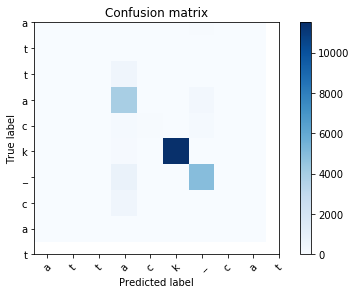

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00       521
           3       0.66      0.92      0.77      4267
           4       0.69      0.17      0.28       448
           5       0.99      0.99      0.99     11640
           6       0.89      0.86      0.88      5737
           7       0.00      0.00      0.00       478
           8       0.00      0.00      0.00        26

    accuracy                           0.88     23271
   macro avg       0.36      0.33      0.32     23271
weighted avg       0.85      0.88      0.86     23271



C:\Users\16696\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [127]:
#Plot Confusion matrix and display classification report
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, predict_neural)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, 'attack_cat')
plt.show()

print(classification_report(y_true, predict_neural))